# Recitation Course on FEM and IE

# Finite Element Method

In [31]:
# Import packages
import numpy as np

# Create mesh, using GMSH

http://linuxg.net/how-to-install-gmsh-2-8-5-on-the-most-popular-linux-systems/
http://gmsh.info 

Why mesh like that? 
Delaunay triangulation for a given set of discrete points in a plane is a triangulation such that no point is inside the circumcircle of any triangle. Delaunay triangulations maximize the minimum angle of all the angles of the triangles in the triangulation (more https://en.wikipedia.org/wiki/Delaunay_triangulation)

In [32]:
# Load processed .txt files
p = np.loadtxt('nodes_2ref.txt')
t = np.loadtxt('triangles_2ref.txt')

# print
print(p)
print(t)

[[  1.           0.           0.           0.        ]
 [  2.           1.           0.           0.        ]
 [  3.           0.           1.           0.        ]
 ...
 [527.           0.79227974   0.90715345   0.        ]
 [528.           0.81075793   0.8623451    0.        ]
 [529.           0.9454054    0.77009422   0.        ]]
[[  1.   2.   2. ...  87. 184. 185.]
 [  2.   2.   2. ... 184.  26. 185.]
 [  3.   2.   2. ... 184.  25.  26.]
 ...
 [974.   2.   2. ... 506. 519. 529.]
 [975.   2.   2. ... 506. 181. 519.]
 [976.   2.   2. ... 529. 519. 167.]]


In [33]:
# Some more post-processing

p = np.delete(p, 3, 1)  # delete fourth column of p
t = np.delete(t, 1, 1)  # delete second column of t
t = np.delete(t, 1, 1)  # delete second column of t
t = np.delete(t, 1, 1)  # delete second column of t
t = np.delete(t, 1, 1)  # delete second column of t

print(p)
print(t)

[[  1.           0.           0.        ]
 [  2.           1.           0.        ]
 [  3.           0.           1.        ]
 ...
 [527.           0.79227974   0.90715345]
 [528.           0.81075793   0.8623451 ]
 [529.           0.9454054    0.77009422]]
[[  1.  87. 184. 185.]
 [  2. 184.  26. 185.]
 [  3. 184.  25.  26.]
 ...
 [974. 506. 519. 529.]
 [975. 506. 181. 519.]
 [976. 529. 519. 167.]]


In [34]:
# Get the number of nodes and triangles
N = int(p[-1,0])
T = int(t[-1,0])

print(N)
print(T)

529
976


### Assembling the matrix

Classical way:

* Notice that $\nabla v_k$ are piecewise constant:
$$
A_{k,\ell}
= \int_{\Omega} \nabla v_k \cdot \nabla v_\ell
= \sum_{T\in\mathcal T} |T| (\nabla v_k|_T) \cdot (\nabla v_\ell|_T),
$$
where $|T|$ is the volume or area of $T$

* Pseudocode:
```
for k = 1 to n
  for l = 1 to n
    for all T
      if(k and l are nodes of T)
      // otherwise the integral is zero
        A(k,l) += |T|
           *(\nabla v_k|_T)
           *(\nabla v_l|_T)
```

* The loops in the algorithm are often reversed:
```
for all T
    for k, vertices of T
        for l, vertices of T
            A(k,l) += <<as before>>
```


* We have
$$
2 |T| = \det \left(
\begin{array}{cc}
x _2 - x _1 & y _2 - y _1 \\
x _3 - x _1 & y _3 - y _1 \\
\end{array}
\right)
$$
Let $T$'s nodes being $n_1$, $n_2$, $n_3$. Denote $\eta_i := v_{n_i}$.
Then it can be shown
$$
\nabla \eta _j = \frac{1}{2|T|}
\left(
\begin{array}{cc}
y _{j+1} - y _{j+2} \\
x _{j+2} - x _{j+1} \\
\end{array}
\right)
$$
Here we mean $(x_4,y_4) = (x_1,y_1)$, $(x_5,y_5) = (x_2,y_2)$

* Pseudocode:
```
for all T
    calculate M
    for k=1..3
        for l=1..3
            A(nodes(k),nodes(l)) += M(k,l)
```


### Assembling the right-hand side (forces)

$$
\int_T f \eta_i \approx f(x_S, y_S) \int_\Omega \eta_i,
$$
where $(x_S,y_S)$ is the center of mass of the triangle. 

* Pseudocode:
```
for all T
  calculate f(xS, yS)
  for k=1..3
    f(nodes(k)) += 1/3 * area(T) * f(xS, yS)
```

### How about boundary conditions?

* pseudocode:
```
A = zero matrix for free nodes
for k = free nodes
    for l = free nodes
        for all T
            <<SAME>>
```
This fills only the needed rows & columns of the matrix, but for convenience the loops in the algorithm are often reversed:

* pseudocode
```
A = zero matrix for all nodes
for all T
    <<SAME>>
remove rows and columns from A corr. to non-free nodes
```

* The **free nodes** are those that are on $\Gamma_2$ in
$$
\begin{align*}
-\Delta u &= 0\qquad\text{on $\Omega$}
\\
u &= 0\qquad\text{on $\Gamma_1$}
\\
u_n &= 0\qquad\text{on $\Gamma_2$}
\end{align*}
$$

* Alternatively, one can **replace** the corresponding row and column by
$$
\begin{pmatrix}
\cdot & 0 & \cdot & \cdot \\
0 & 1 & 0 & 0\\
\cdot & 0 & \cdot & \cdot \\
\cdot & 0 & \cdot & \cdot \\
\end{pmatrix}
$$

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.07064266 0.0577692  0.04591543 0.0447374
 0.05439984 0.02625173 0.01114588 0.05512693 0.07092059 0.05628082
 0.04172896 0.04099414 0.06818172 0.06719163 0.05565985 0.05604654
 0.0361621  0.02697483 0.03571443

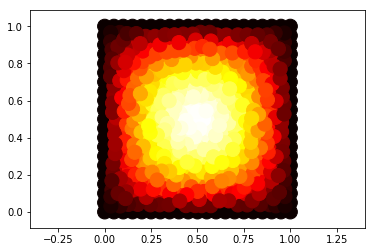

In [35]:
# Solve the simplest problem -Du = 1, Dirichlet boundary conditions

A = np.zeros((N,N))
b = np.zeros(N)

# One big loop for all triangles
for i in range(0,T):
    
    # Extract the vertices of the triangles
    p1 = p[int(t[i,1])-1,1:3] #x1,y1
    p2 = p[int(t[i,2])-1,1:3] #x2,y2
    p3 = p[int(t[i,3])-1,1:3] #x3,y3
    
    verts = np.stack((p1, p2, p3)) # Put vertices into one array
    
    # Find the area of the triangle
    T_area = np.linalg.det([[p2[0]-p1[0],p2[1]-p1[1]],[p3[0]-p1[0],p3[1]-p1[1]]])/2
    
    # Loop for the nodes
    for k in range(0,3):
        for j in range(0,3):
            
            # Index
            k1 = (k+1)%3
            k2 = (k+2)%3
            j1 = (j+1)%3
            j2 = (j+2)%3
            
            # Gradients
            grad1 = np.array([verts[k1,1]-verts[k2,1],verts[k2,0]-verts[k1,0]])
            grad2 = np.array([[verts[j1,1]-verts[j2,1]],[verts[j2,0]-verts[j1,0]]])
            
            # Fill the matrix
            A[int(t[i,j+1])-1,int(t[i,k+1])-1] += 1./(4*T_area)*np.dot(grad1,grad2) 
        
        # Right hand side
        b[int(t[i,k+1])-1] += 1/3*T_area;

# Boundary Conditions
for n in range(0,N):
    if p[n,1] == 0.0 or p[n,2] == 0.0 or p[n,1] == 1.0 or p[n,2] == 1.0:
        A[n,:] = 0
        A[:,n] = 0
        A[n,n] = 1
        b[n] = 0

sol = np.linalg.solve(A, b)
print(sol)

import matplotlib.pyplot as plt
plt.scatter(p[:,1], p[:,2], c=sol,s=200)
plt.axis('equal')
plt.hot()

plt.show()

## Integral Equations

In [75]:
from scipy.linalg import toeplitz

num = 5

A = toeplitz(np.random.rand(num,1)) # Define a random Toeplitz matrix
J = np.random.rand(num) # Define a random vector of unknowns

# Classic implementation
x_1 = A.dot(J) #n^3 complexity

# fft-based accelerated product
A_toep = A[:,0] # Find the defining vector

# Circulant embedding
A_circ = np.zeros(2*num)
A_circ[0:num] = A_toep
A_circ[num] = 0
A_circ[num+1:2*num] = np.flipud(A_toep)[0:num-1] 

# We have just one singular integral in the beginning of the array
# You need to do it in the two dimensional case!

print(A_toep)
print(A_circ) 

[0.67424986 0.88630554 0.87312363 0.31629411 0.29974513]
[0.67424986 0.88630554 0.87312363 0.31629411 0.29974513 0.
 0.29974513 0.31629411 0.87312363 0.88630554]


In [76]:
# Implement the fft

A_fft = np.fft.fft(A_circ) # In the 2d case, you just need to do a two-dimensional fft

# Since we want to implement element wise product product we will pad the unknown with zeros

J_pad = np.zeros(2*num)
J_pad[0:num] = J

print(J)
print(J_pad)

[0.7959625  0.38282661 0.53701211 0.25242204 0.37068945]
[0.7959625  0.38282661 0.53701211 0.25242204 0.37068945 0.
 0.         0.         0.         0.        ]


In [77]:
# Fourier on the unknowns

J_fft = np.fft.fft(J_pad)

# Element-wise product

sol = np.multiply(A_fft,J_fft)

# inverse fourier on the solution (again 2d on your case)

sol = np.fft.ifft(sol)
# Remove the extra elements from the padding

x_2 = sol[0:num]

print(np.absolute(x_2)) # absolute value for visualization
print(np.absolute(x_1))

[1.53580888 1.77718611 1.94373612 1.56070966 1.30221001]
[1.53580888 1.77718611 1.94373612 1.56070966 1.30221001]


In [89]:
#Implement the matrix vector product with gmres
import numpy as np
import scipy.sparse.linalg as it
from scipy import *

num = 5;
A = toeplitz(np.random.rand(num,1)) # Define a random Toeplitz matrix
A_toep = A[:,0] 
A_circ = np.zeros(2*num)
A_circ[0:num] = A_toep
A_circ[num] = 0
A_circ[num+1:2*num] = np.flipud(A_toep)[0:num-1]
A_fft = np.fft.fft(A_circ)

def iterative_method(q):

    # num is the length of x
    # In the 2d case I need to reshape the vector to a matrix
    
    q_pad = np.zeros(2*num)
    q_pad[0:num] = q
    q_fft = np.fft.fft(q_pad)
    q_2 = np.fft.ifft(np.multiply(A_fft,q_fft))
    q = q_2[0:num]
    # In the 2d case I need to reshape the matrix to a vector 
    return np.array(q);

def res(r):
    res_gmres.append(r)

res_gmres=[]

f = np.random.rand(num) #right hand side
q = np.ones(num)
A = it.LinearOperator((num,num), matvec=iterative_method)


In [90]:
# Iterative solver of your choice / bicgstab is another good option
sol = it.gmres(A,f,tol=1e-5,restart=50,maxiter=200,callback=res) # Iterative Solver

print(sol)
print(res_gmres)

(array([-0.51277596+2.18146340e-15j,  0.9042094 -4.27645230e-16j,
        0.69796259-8.27274222e-16j, -0.66963881-1.30345878e-15j,
        0.79209576-2.11957292e-19j]), 0)
[0.2851284618545296, 0.13350333573873785, 0.1328464480516174, 0.0884843728183435, 2.810848164955259e-18]


/home/ilias/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
